<a href="https://colab.research.google.com/github/rliu7926/nie-research-project/blob/master/4.4%20Spin%20Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Create waveform function (taken from Section 3.1)

def create_waveform(mass1=30, mass2=30, spin1=[0, 0, 0], spin2=[0, 0, 0], resolution=1.0/1024, frequencybound=20, distance=500, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant=approximant,
                                             mass1=mass1, mass2=mass2,
                                             spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                             spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/lum_dist for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Create frequency series waveform function (for expectation value function)

def create_fd_waveform(mass1, mass2, spin1, spin2, fres, flow, dist, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, dist * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  flow_bound = flow * redshift

  hplus, hcross = get_fd_waveform(approximant=approximant,
                                  mass1=mass1, mass2=mass2,
                                  spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                  spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                  delta_f=fres * redshift,
                                  f_lower=flow_bound)
  
  freq_value = hplus.sample_frequencies / redshift
  freq_amp = hplus / lum_dist * redshift

  return freq_amp, freq_value


In [ ]:
## Expectation value function (taken from 4.1)

def expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist, tdist, psd, cosmology=Planck18, approximant="IMRPhenomD", output="Yes"):

  ## Create waveform and template

  gw_amp, gw_value = create_fd_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, fres=fres, flow=flow, dist=dist, approximant=approximant)
  signal_amp, signal_value = create_fd_waveform(mass1=tmass1, mass2=tmass2, spin1=tspin1, spin2=tspin2, fres=fres, flow=flow, dist=tdist, approximant=approximant)

  gwfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=gw_amp, delta_f=fres)
  signalfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=signal_amp, delta_f=fres)

  ## Create PSD 

  flen = len(gw_value)

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, fres, flow)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, fres, flow)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, fres, flow)
    

  ## Calculate SNR

  gwdata = gwfreq + psdfreq
  snr = matched_filter(template=signalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=flow)

  if output == 'Yes':
    print("The signal-to-noise ratio is: {}".format(max(abs(snr))))
  
  return(max(abs(snr)))
  

In [ ]:
## Distance estimation function, updated with new parameters

def estimate_distance(snr, guess, alpha, iterations, tolerance, mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, approximant='IMRPhenomD', output='Yes'): 
  
  if dist == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, guess, guess, psd, cosmology, approximant)
    print("Initial guess: {}".format(estimate))

    diff = 1
    iter = 0

    while iter < iterations and abs(diff) > tolerance:
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, pred, pred, psd, cosmology, approximant)
      iter = iter + 1
      print("Iteration {}: Estimate {}, Distance {}".format(iter, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

In [ ]:
## Distance estimation function for varying spins in the z-direction 

spins = np.arange(-0.9, 1, 0.1)

aligo, aplus, cosmic = (np.zeros((len(spins), len(spins))) for i in range(3))
dist = [aligo, aplus, cosmic]
guess = [6000, 7000, 11000]
alpha = [-100, -100, -20]
psd = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

for i in range(len(dist)):
  for s in range(len(spins)):
    for t in range(len(spins)):
        dist[i][s][t], error = estimate_distance(snr=8, guess=guess[i], alpha=alpha[i], iterations=200, tolerance=10**-4,
                                                 mass1=30, mass2=30, spin1=[0,0,spins[s]], spin2=[0,0,spins[t]],
                                                 tmass1=30, tmass2=30, tspin1=[0,0,spins[s]], tspin2=[0,0,spins[s]],
                                                 res=1.0/1024, fres=1.0/16, flow=20, dist='param', psd=psd[i], cosmology=Planck18)
        print("--------------------------------------------- PSD: {}, Spin: {}, {}".format(psd[i], spins[s], spins[t]))

for i in range(len(dist)):
  for r in range(len(spins)):
    for c in range(len(spins)):
      dist[i][r][c] = z_at_value(Planck18.comoving_distance, dist[i][r][c] * u.Mpc)


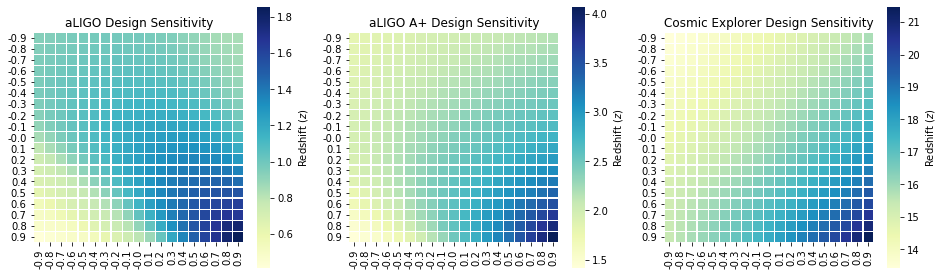

In [ ]:
fig = plt.figure(figsize = (16.0,4.8))

snrtitle=['aLIGO', 'aLIGO A+', 'Cosmic Explorer']

spins = np.arange(-0.9, 1, 0.1)
spins = np.around(spins, decimals=1)

for i in range(len(dist)):
  heatmap = pd.DataFrame(dist[i], columns=spins, index=spins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0.25, cmap="YlGnBu", square="True", cbar_kws={'label': 'Redshift ($z$)'}).set(title="{} Design Sensitivity".format(snrtitle[i]))


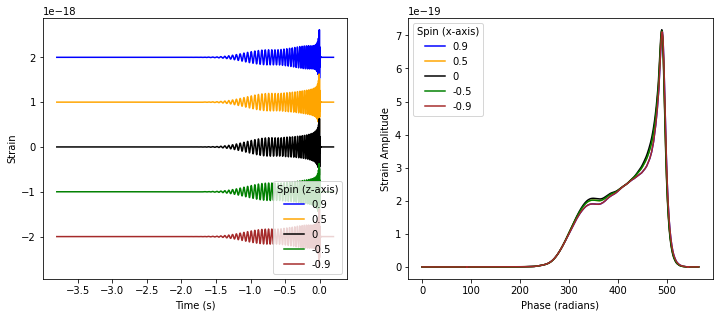

In [ ]:
## Visualization for varying spins in the x-direction 

normalamp, normaltime = create_waveform(distance=1, approximant='IMRPhenomPv2')
spin5xamp, spin5xtime = create_waveform(spin1=[0.5, 0, 0], spin2=[0.5, 0, 0], distance=1, approximant='IMRPhenomPv2')
spinneg5xamp, spinneg5xtime = create_waveform(spin1=[-0.5, 0, 0], spin2=[-0.5, 0, 0], distance=1, approximant='IMRPhenomPv2')
spin9xamp, spin9xtime = create_waveform(spin1=[0.99, 0, 0], spin2=[0.99, 0, 0], distance=1, approximant='IMRPhenomPv2')
spinneg9xamp, spinneg9xtime = create_waveform(spin1=[-0.99, 0, 0], spin2=[-0.99, 0, 0], distance=1, approximant='IMRPhenomPv2')

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

plt.plot(spin9xtime, spin9xamp + 2 * 10**-18, color = "blue")
plt.plot(spin5xtime, spin5xamp + 1 * 10**-18, color = "orange")
plt.plot(normaltime, normalamp, color="black")
plt.plot(spinneg5xtime, spinneg5xamp - 1 * 10**-18, color = "green")
plt.plot(spinneg9xtime, spinneg9xamp - 2 * 10**-18, color = "brown")
plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (x-axis)")
plt.ylabel("Strain")
plt.xlabel("Time (s)")

plt.subplot(1,2,2)

spins = [0.99, 0.5, 0, -0.5, -0.99]
colors = ["blue", "orange", "black", "green", "brown"]
for i in range(len(spins)):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2", mass1=30, mass2=30, spin1x=spins[i], delta_t=1.0/1024, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    pylab.plot(phase, amp, color = colors[i])

plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (x-axis)")
plt.ylabel("Strain Amplitude")
plt.xlabel("Phase (radians)")
fig.show()


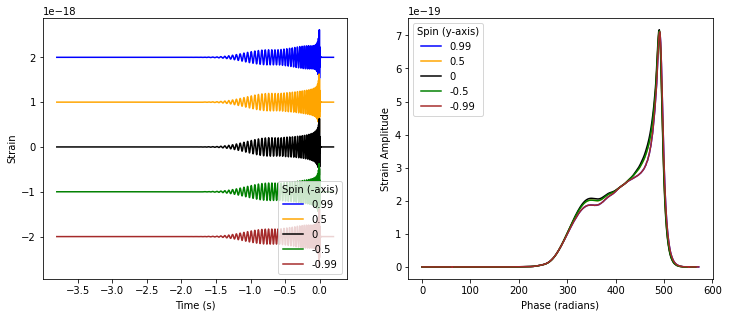

In [ ]:
## Visualization for varying spins in the y-direction 

normalamp, normaltime = create_waveform(distance=1, approximant='IMRPhenomPv2')
spin5yamp, spin5ytime = create_waveform(spin1=[0, 0.5, 0], spin2=[0, 0.5, 0], distance=1, approximant='IMRPhenomPv2')
spinneg5yamp, spinneg5ytime = create_waveform(spin1=[0, -0.5, 0], spin2=[0, -0.5, 0], distance=1, approximant='IMRPhenomPv2')
spin9yamp, spin9ytime = create_waveform(spin1=[0, 0.99, 0], spin2=[0, 0.99, 0], distance=1, approximant='IMRPhenomPv2')
spinneg9yamp, spinneg9ytime = create_waveform(spin1=[0, -0.99, 0], spin2=[0, -0.99, 0], distance=1, approximant='IMRPhenomPv2')

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

plt.plot(spin9ytime, spin9yamp + 2 * 10**-18, color = "blue")
plt.plot(spin5ytime, spin5yamp + 1 * 10**-18, color = "orange")
plt.plot(normaltime, normalamp, color="black")
plt.plot(spinneg5ytime, spinneg5yamp - 1 * 10**-18, color = "green")
plt.plot(spinneg9ytime, spinneg9yamp - 2 * 10**-18, color = "brown")
plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (-axis)")
plt.ylabel("Strain")
plt.xlabel("Time (s)")

plt.subplot(1,2,2)

spins = [0.99, 0.5, 0, -0.5, -0.99]
colors = ["blue", "orange", "black", "green", "brown"]
for i in range(len(spins)):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2", mass1=30, mass2=30, spin1y=spins[i], delta_t=1.0/1024, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    pylab.plot(phase, amp, color = colors[i])

plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (y-axis)")
plt.ylabel("Strain Amplitude")
plt.xlabel("Phase (radians)")
fig.show()


In [ ]:
## Distance estimation function for varying spins in the x- and y-directions

spins = np.arange(-0.7, 0.8, 0.1)

aligo, aplus, cosmic = (np.zeros((len(spins), len(spins))) for i in range(3))
dist = [aligo, aplus, cosmic]
guess = [6000, 7000, 11000]
alpha = [-100, -100, -20]
psd = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

for i in range(len(dist)):
  for s in range(len(spins)):
    for t in range(len(spins)):
        dist[i][s][t], error = estimate_distance(snr=8, guess=guess[i], alpha=alpha[i], iterations=200, tolerance=10**-4,
                                                 mass1=30, mass2=30, spin1=[spins[s], spins[t], 0], spin2=[0,0,0],
                                                 tmass1=30, tmass2=30, tspin1=[spins[s], spins[t], 0], tspin2=[0,0,0],
                                                 res=1.0/1024, fres=1.0/16, flow=20, dist='param', psd=psd[i], cosmology=Planck18, approximant='IMRPhenomPv2')
        print("--------------------------------------------- PSD: {}, Spin: {}, {}".format(psd[i], spins[s], spins[t]))

for i in range(len(dist)):
  for r in range(len(spins)):
    for c in range(len(spins)):
      dist[i][r][c] = z_at_value(Planck18.comoving_distance, dist[i][r][c] * u.Mpc)


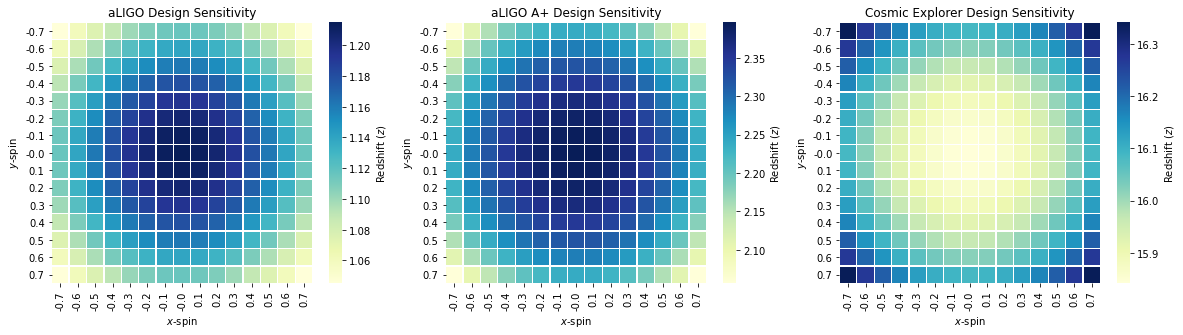

In [ ]:
fig = plt.figure(figsize = (20.0,4.8))

snrtitle=['aLIGO', 'aLIGO A+', 'Cosmic Explorer']

spins = np.arange(-0.7, 0.8, 0.1)
spins = np.around(spins, decimals=1)

for i in range(len(dist)):
  heatmap = pd.DataFrame(dist[i], columns=spins, index=spins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0.25, cmap="YlGnBu", square="True", cbar_kws={'label': 'Redshift ($z$)'}).set(title="{} Design Sensitivity".format(snrtitle[i]), xlabel="$x$-spin", ylabel="$y$-spin")


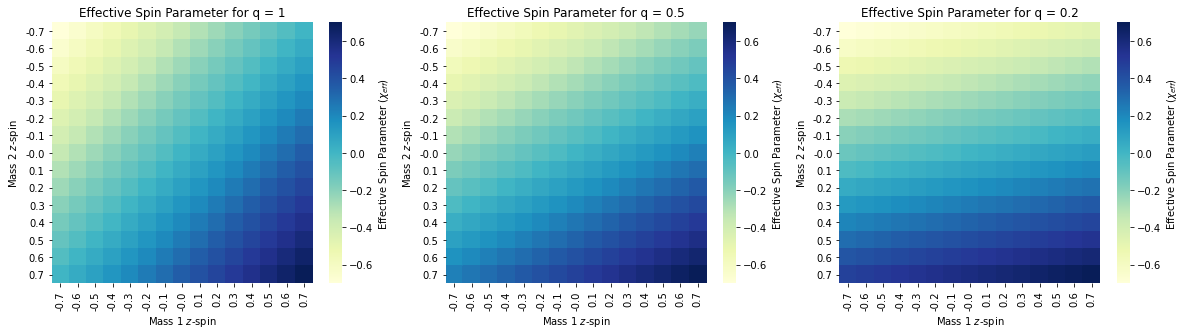

In [ ]:
## Effective spin parameter

def chieff(q, s1z, s2z):
  return (s1z + q*s2z) / (1 + q)

## Plot effective spin parameter

zspins = np.arange(-0.7, 0.8, 0.1)
chieff1, chieff3, chieff5 = (np.zeros((len(zspins), len(zspins))) for i in range(3))

for i in range(len(zspins)):
  for j in range(len(zspins)):
    chieff1[i][j] = chieff(1, zspins[i], zspins[j])
    chieff3[i][j] = chieff(0.5, zspins[i], zspins[j])
    chieff5[i][j] = chieff(0.2, zspins[i], zspins[j])

chieffs = [chieff1, chieff3, chieff5]
ratios = ["1", "0.5", "0.2"]

fig = plt.figure(figsize = (20.0, 4.8))
zspins = np.around(zspins, decimals=2)

for i in range(len(chieffs)):
  heatmap = pd.DataFrame(chieffs[i], columns=zspins, index=zspins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'Effective Spin Parameter ($\chi_{eff}$)'}).set(title="Effective Spin Parameter for q = {}".format(ratios[i]), xlabel="Mass 1 $z$-spin", ylabel="Mass 2 $z$-spin")


In [ ]:
chieff1_dist, chieff3_dist, chieff5_dist = (np.zeros((len(zspins), len(zspins))) for i in range(3))
chieff_dists = [chieff1_dist, chieff3_dist, chieff5_dist]
qvals = [1, 0.5, 0.2]

for i in range(len(chieff_dists)):
  for j in range(len(zspins)):
    for k in range(len(zspins)):
      chieff_dists[i][j][k], error = estimate_distance(snr=8, guess=3000, alpha=-100, iterations=200, tolerance=0.001,
                                                       mass1=50, mass2=50*qvals[i], spin1=[0, 0, zspins[j]], spin2=[0, 0, zspins[k]],
                                                       tmass1=50, tmass2=50*qvals[i], tspin1=[0, 0, zspins[j]], tspin2=[0, 0, zspins[k]],
                                                       res=1.0/1024, fres=1.0/16, flow=20, approximant='IMRPhenomPv2')
      print("--------------------------------------------- Mass ratio: {}, Spin 1: {}, Spin 2: {}".format(qvals[i], zspins[j], zspins[k]))

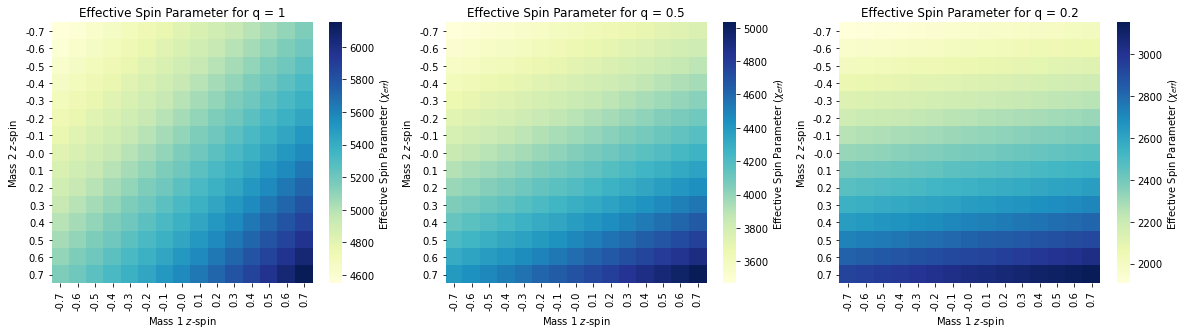

In [ ]:
fig = plt.figure(figsize = (20.0, 4.8))
zspins = np.around(zspins, decimals=2)

for i in range(len(chieffs)):
  heatmap = pd.DataFrame(chieff_dists[i], columns=zspins, index=zspins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'Effective Spin Parameter ($\chi_{eff}$)'}).set(title="Effective Spin Parameter for q = {}".format(ratios[i]), xlabel="Mass 1 $z$-spin", ylabel="Mass 2 $z$-spin")


In [ ]:
pylab.plot(chieff1_dist, chieff1)
pylab.plot(chieff3_dist, chieff3)
pylab.plot(chieff5_dist, chieff5)

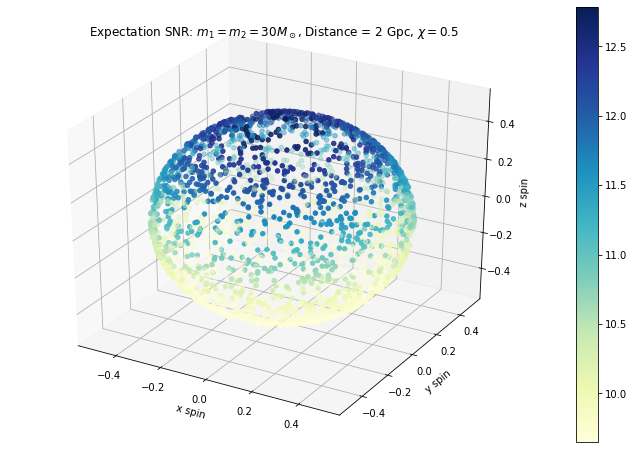

In [ ]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
x, y, z = (get_truncated_normal(mean=0, sd=1, low=-1, upp=1) for i in range(3))
xvals = x.rvs(2500)
yvals = y.rvs(2500)
zvals = z.rvs(2500)

for i in range(2500):
  r = np.sqrt(xvals[i]**2 + yvals[i]**2 + zvals[i]**2)
  xvals[i] = xvals[i] / (2*r)
  yvals[i] = yvals[i] / (2*r)
  zvals[i] = zvals[i] / (2*r)

snr = [0] * 2500
for i in range(len(snr)):
  snr[i] = expectation_SNR(mass1=30, mass2=30, spin1=[xvals[i], yvals[i], zvals[i]], spin2=[xvals[i], yvals[i], zvals[i]],
                           tmass1=30, tmass2=30, tspin1=[xvals[i], yvals[i], zvals[i]], tspin2=[xvals[i], yvals[i], zvals[i]],
                           res=1.0/1024, fres=1.0/16, flow=20, dist=2000, tdist=2000, psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, approximant='IMRPhenomPv2', output='No')

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection ='3d')
p = ax.scatter(xvals, yvals, zvals, c=snr, cmap="YlGnBu")
ax.set_xlabel('x spin')
ax.set_ylabel('y spin')
ax.set_zlabel('z spin')
fig.colorbar(p, ax=ax)
 
# syntax for plotting
ax.set_title('Expectation SNR: $m_1 = m_2 = 30 M_\odot$, Distance = 2 Gpc, $\chi = 0.5$ ')
plt.show()

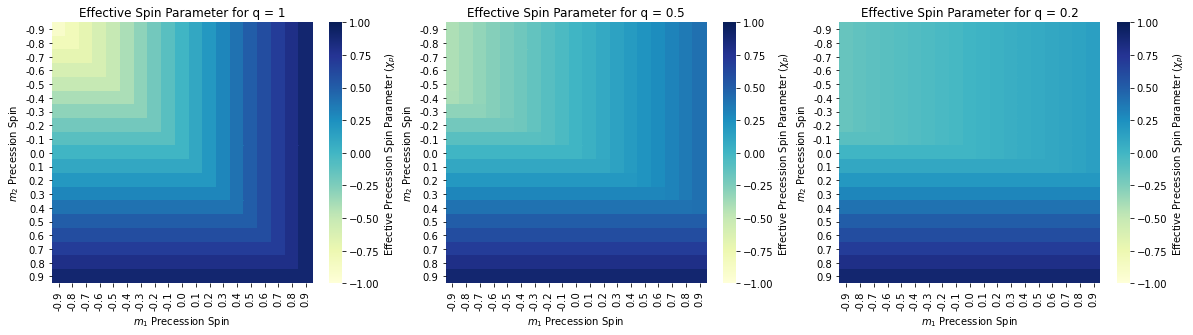

In [ ]:
## EFfective precession spin parameter
def chip(q, s1xy, s2xy):
  return max(s1xy, (4*q+3)/(4+3*q)*q*s2xy)

spin1, spin2 = (np.linspace(-0.9, 0.9, 19) for i in range(2))
chipvals1, chipvals2, chipvals5 = (np.zeros((len(spin1), len(spin2))) for i in range(3))

for i in range(len(spin1)):
  for j in range(len(spin2)):
    chipvals1[i][j] = chip(1, spin1[i], spin2[j])
    chipvals2[i][j] = chip(0.5, spin1[i], spin2[j])
    chipvals5[i][j] = chip(0.2, spin1[i], spin2[j])

chipvals = [chipvals1, chipvals2, chipvals5]
ratios = [1, 0.5, 0.2]

fig = plt.figure(figsize=(20, 4.8))

for i in range(len(chipvals)):
  heatmap = pd.DataFrame(chipvals[i], columns=np.around(spin1, decimals=1), index=np.around(spin2, decimals=1))
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, vmin=-1, vmax=1, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'Effective Precession Spin Parameter ($\chi_{p}$)'}).set(title="Effective Spin Parameter for q = {}".format(ratios[i]), xlabel="$m_1$ Precession Spin", ylabel="$m_2$ Precession Spin")
